In [1]:
using JuMP
using HiGHS
import Random 
using Plots 

In [12]:
x = [1,2,3]
x[1:2]

2-element Vector{Int64}:
 1
 2

In [13]:
rng = Random.MersenneTwister(1234);

## One fake house which everyone hates to reflect an empty allocation  
function generate_prefs(n,h)
    prefs = zeros(h+1, n)
    for i=1:n 
        prefs[1:h, i] = Random.shuffle(rng, 1:h)
    end 
    prefs[h+1, :] .= h+1 
    return prefs 
end 


function generate_caps(h, m_cap)
    caps = zeros(h+1)
    caps[1:h] = rand(1:m_cap, h) 
    caps[h+1] = Inf 
    return caps 
end 

function limited_lot_house!(prefs, all, house, cap, used, k) 
    n = size(prefs)[2]
    n_changed = 0 
    lottery = []
    for pp=1:n
        h = all[pp]
        my_score = prefs[h, pp] 
        upgrade = prefs[house, pp]
        if upgrade < k && upgrade < my_score 
            push!(lottery, pp) 
        end 
    end 
    Random.shuffle!(lottery)
    while used[house] < cap[house] && length(lottery) > 0 
        lucky = pop!(lottery) 
        old = all[lucky]
        used[old] -= 1
        all[lucky] = house 
        used[house] += 1 
        n_changed += 1 
    end 
    return n_changed 
end 

function limited_lottery_round!(prefs, all, cap, used,k)
    n_changed = 0 
    n_houses = size(prefs)[1]
    for h=1:n_houses
        if used[h] == cap[h] 
            continue
        end 
        n_changed += limited_lot_house!(prefs, all, h, cap, used,k)
    end 
    return n_changed
end 

function limited_lottery!(prefs, all, cap, used,k)
    n_changed = 1 
    total = 0 

    while n_changed != 0 
        n_changed = limited_lottery_round!(prefs, all, cap, used,k)
        total += 1
    end 
    return total
end 

function lottery_round_house!(prefs, all, house, cap, used)
    n = size(prefs)[2]
    n_changed = 0 
    lottery = []
    for pp=1:n
        h = all[pp]
        #my_score = findfirst( prefs[:, pp] .== h )
        #upgrade =  findfirst( prefs[:, pp] .== house)
        my_score = prefs[h, pp] 
        upgrade = prefs[house, pp]
        if my_score > upgrade 
            push!(lottery, pp) 
        end 
    end 
    Random.shuffle!(lottery)
    while used[house] < cap[house] && length(lottery) > 0 
        lucky = pop!(lottery) 
        old = all[lucky]
        used[old] -= 1
        all[lucky] = house 
        used[house] += 1 
        n_changed += 1 
    end 
    return n_changed 
end 

function lottery_round!(prefs, all, cap, used)
    n_changed = 0 
    n_houses = size(prefs)[1]
    for h=1:n_houses
        if used[h] == cap[h] 
            continue
        end 
        n_changed += lottery_round_house!(prefs, all, h, cap, used)
    end 
    return n_changed
end 

function lottery!(prefs, all, cap, used)
    n_changed = 1 
    total = 0 

    while n_changed != 0 
        n_changed = lottery_round!(prefs, all, cap, used)
        total += 1
    end 
    return total
end 



function score(prefs, all)
    total = 0 
    for i=1:n 
        total += prefs[all[i], i] 
    end 
    return total 
end 

function score_numeric(prefs_num, prefs, all) 
    total = 0 
    n = size(prefs)[2]
    
    for i=1:n 
        place =  findfirst( prefs[:, i] .== all[i]) 
        total += prefs_num[place, i]
    end  
    return total 
end    





score_numeric (generic function with 1 method)

In [18]:
function rand_all!(allo, cap)
    n = length(allo) 
    h = length(cap) 
    head = 1 
    for j=1:h 
       used = 0 
       while head < n && used < cap[j]
            allo[head] = j 
            head += 1 
            used += 1
       end 
    end  
end
rand_all!(allo, caps)

In [17]:
n = 5000
houses = 200
prefs = generate_prefs(n, houses)
#caps = generate_caps(houses, 30)
caps = ones(houses+1)
caps[1:houses] .= 30
caps[houses+1] = Inf 
allo = (houses + 1) * ones(Int32, n)
used[houses+1] = n  


usage = zeros(houses)
orig_caps = copy(caps)

n_rounds = 1 

1

In [21]:
function reset!(allo, used, caps, n, houses)
    allo .= (houses +1)
    used .= 0 
    used[houses+1] = 1 
end 

reset! (generic function with 1 method)

In [24]:
reset!(allo, used, caps, n, houses)

1

In [25]:
util = zeros(houses)
util2 = zeros(houses)
util5p = zeros(houses)
utilrand = zeros(houses)
usage = zeros(houses)
used = zeros(houses+1)

reset!(allo, used, caps, n, houses)
for i=1:200
    caps[1:i] .= 0 
    for k=1:n_rounds
        lottery!(prefs, allo, caps, used)
        util[i] = score(prefs, allo)/n
        reset!(allo, used, caps, n, houses)
        caps[1:i] .= 0 
        limited_lottery!(prefs, allo, caps, used, houses/2) 
        util2[i] = score(prefs, allo)/n
        usage[i] = (sum(used[1:houses]))/n 
        reset!(allo, used, caps, n, houses)
        caps[1:i] .= 0 
        rand_all!(allo, caps)
        utilrand[i] = score(prefs, allo)/n
        reset!(allo, used, caps, n, houses) 
        global caps = copy(orig_caps)

    end 
    
end 



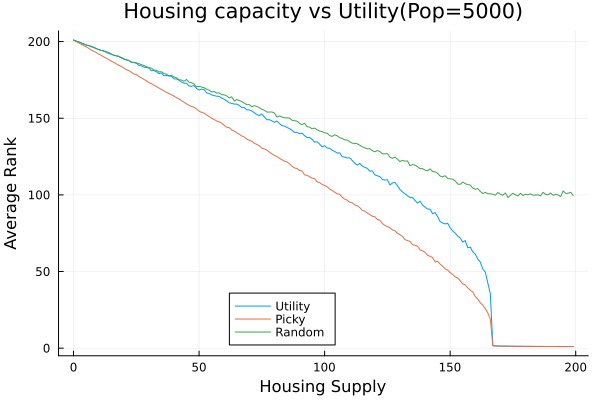

In [26]:
x_axis = (houses)*ones(houses) - [i for i=1:200]
plot()
plot(x_axis , util, label="Utility", legend=:bottom)
plot!(x_axis, util2, label="Picky")
#plot!(x_axis, usage, color="red", label="usage rate")

plot!(x_axis, utilrand, label="Random")


title!("Housing capacity vs Utility(Pop="*string(n) *")")
xlabel!("Housing Supply")
ylabel!("Average Rank")


In [ ]:
x = 3

In this model being selective is better for everyone. Because there are fewer applicants in each pool? 

In [31]:
caps

In [28]:
model = Model(HiGHS.Optimizer)
all2 = zeros(houses+1, n )
@variable(model, 0 <= all2[1:houses+1, 1:n] <= 1 )
#@variable(model, 0 <= all2[1:houses+1, 1:n] <= 1)
@objective(model, Min, sum( all2 .* prefs)  )
for i=1:n
    @constraint(model,  sum(all2[1:houses+1, i]) == 1)
end 
# for i=1:n 
#     @constraint(model, all2[1:houses, i]' * prefs[1:houses, i] <= prefs[all[i], i] )
# end 
for j=1:houses
    @constraint(model,  sum(all2[j, 1:n]) <= caps[j] )
end 


In [29]:
display(model)

A JuMP Model
Minimization problem with:
Variables: 1005000
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 5000 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 200 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1005000 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 1005000 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: all2

In [30]:
optimize!(model)

Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
5200 rows, 1005000 cols, 2005000 nonzeros
5200 rows, 1005000 cols, 2005000 nonzeros
Presolve : Reductions: rows 5200(-0); columns 1005000(-0); elements 2005000(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5000(5000) 1s
       5043     5.0960000000e+03 Pr: 0(0) 2s
Model   status      : Optimal
Simplex   iterations: 5043
Objective value     :  5.0960000000e+03
HiGHS run time      :          2.51


In [7]:
import Pkg; Pkg.add("Ipopt")

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [b6b21f68] + Ipopt v1.2.1
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [b6b21f68] + Ipopt v1.2.1
  [ae81ac8f] + ASL_jll v0.1.3+0
  [9cc047cb] + Ipopt_jll v300.1400.1000+0
  [d00139f3] + METIS_jll v5.1.2+0
  [d7ed1dd3] + MUMPS_seq_jll v500.500.101+0
⌅ [656ef2d0] + OpenBLAS32_jll v0.3.17+0
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
Precompiling project...
  ✓ OpenBLAS32_jll
  ✓ ASL_jll
  ✓ METIS_jll
  ✓ MUMPS_seq_jll
  ✓ Ipopt_jll
  ✓ Ipopt
  6 dependencies successfully precompiled in 19 seconds. 208 already precompiled.


In [3]:
import Ipopt
using Juniper

In [36]:
nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
minlp_solver = optimizer_with_attributes(Juniper.Optimizer, "nl_solver"=>nl_solver)
m = Model(minlp_solver)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Juniper

In [37]:
d = 0.01

f = 1.000
@variable(m, 0 <= p1 <= 1)
@variable(m, 0 <= q1 <= 1)
@variable(m, 0 <= p2 <= 1)
@variable(m, 0 <= q2 <= 1)
@variable(m, 0 <= p3 <= 1)
@variable(m, 0 <= q3 <= 1)
@variable(m, 1e-4 <= v1 )
@variable(m, 1e-4 <= v2)
@variable(m, 1e-4 <= v3)
@variable(m, y12, Bin)
@variable(m, y13, Bin)
@variable(m, y21, Bin)
@variable(m, y23, Bin)
@variable(m, y31, Bin)
@variable(m, y32, Bin)
@variable(m, y1, Bin)
@variable(m, y2, Bin)
@variable(m, y3, Bin)
@variable(m, A[1:3, 1:3])
@constraint(m, v1 >= v2)
@constraint(m, v2 >= v3)


@NLconstraint(m, A[1,1] == p1*q1*(1-d)/(d+p1*q1*(1-d)))
@NLconstraint(m, A[1,2] == p1*q2*(1-d)/(d+p1*q2*(1-d)))
@NLconstraint(m, A[1,3] == p1*q3*(1-d)/(d+p1*q3*(1-d)))
@NLconstraint(m, A[2,1] == p2*q1*(1-d)/(d+p2*q1*(1-d)))
@NLconstraint(m, A[2,2] == p2*q2*(1-d)/(d+p2*q2*(1-d)))
@NLconstraint(m, A[2,3] == p2*q3*(1-d)/(d+p2*q3*(1-d)))
@NLconstraint(m, A[3,1] == p3*q1*(1-d)/(d+p3*q1*(1-d)))
@NLconstraint(m, A[3,2] == p3*q2*(1-d)/(d+p3*q2*(1-d)))
@NLconstraint(m, A[3,3] == p3*q3*(1-d)/(d+p3*q3*(1-d)))

@constraint(m, q3 >= q2)
@constraint(m, q2 >= q1)
@constraint(m, q3 == 1)
@NLconstraint(m, p1 == 1/(200*q1)  )
@NLconstraint(m, p2 == 1/(200*q2)  )
@NLconstraint(m, p3 == 1/(200*q3)  )



@constraint(m, y13 >= y1)
@constraint(m, y21 + y23 >= y2)
@constraint(m, y31  >= y3)
@NLconstraint(m, y12 * f * v1 * A[1,1] <= (1/q2)*(q1*v1 + (q2-q1)*v2)*A[1,2] )
@NLconstraint(m, y13 * f * v1 * A[1,1] <= (q1*v1 + (q2-q1)*v2+(1-q2)*v3)*A[1,3] )
@NLconstraint(m, y21 * f * (1/q2)*(q1*v1 + (q2-q1)*v2) * A[2,2] <= v1*A[2,1] )
@NLconstraint(m, y23 * f * (1/q2)*(q1*v1 + (q2-q1)*v2) * A[2,2] <= (q1*v1+(q2-q1)*v2+(1-q2)*v3)*A[2,3] )
@NLconstraint(m, y31 * f  * (q1*v1 + (q2-q1)*v2+(1-q2)*v3) * A[3,3] <= v1*A[3,1] )
@NLconstraint(m, y32 * f * (q1*v1 + (q2-q1)*v2+(1-q2)*v3) * A[3,3] <= (1/q2)*(q1*v1+(q2-q1)*v2)*A[3,2] )

# @NLconstraint(m, y12*q2*v1*q1*(d+p1*q2*(1-d)) <= (q1*v1+0.4*v2)*q2*(d+p1*q1*(1-d)))
# @NLconstraint(m, y13*v1*q1*(d+p1*q3*(1-d)) <= (q1*v1+0.4*v2+0.5*v3)*q3*(d+p1*q1*(1-d)))

# @NLconstraint(m, y21*(0.1*v1+0.4*v2)*q2*(d+p2*q1*(1-d)) <= (q2)*v1*q2*(d+p2*q2*(1-d)))
# @NLconstraint(m, y23*(q1*v1+0.4*v2)*q2*(d+p2*q3*(1-d)) <= (q2)*(q1*v1+0.4*v2+0.5*v3)*q3*(d+p2*q2*(1-d)))

# @NLconstraint(m, y31*(q1*v1+0.4*v2+0.5*v3)*q3*(1-d)/(d+p3*q3*(1-d)) <= v1*q1*(1-d)/(d+p3*q1*(1-d)))
# @NLconstraint(m, y32*(q1*v1+0.4*v2+0.5*v3)*q3*(1-d)/(d+p3*q3*(1-d)) <= 2*(0.1*v1+0.4*v2)*q2*(1-d)/(d+p3*q2*(1-d)))


@objective(m, Max, y1  +   y3)



y1 + y3

In [38]:
optimize!(m)

nl_solver         : MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("print_level") => 0])
feasibility_pump  : false
log_levels        : [:Options, :Table, :Info]

#Variables: 27
#IntBinVar: 9
Obj Sense: Max



Incumbent using start values: 0.0
Status of relaxation: LOCALLY_SOLVED
Time for relaxation: 0.15107107162475586
Relaxation Obj: 2.000000013198438

 ONodes   CLevel          Incumbent                   BestBound            Gap    Time   Restarts  GainGap  
    2       2                0.0                         2.0              Inf%    0.6       0         -     


    3       3                0.0                         2.0              Inf%    0.7       -       340.6%  
    4       4                0.0                         2.0              Inf%    0.7       -       328.7%  


    0       5            2.0000000123                2.0000000123         0.0%    0.8       -       64.6%   

#branches: 4
Obj: 2.0000000123488784


In [39]:
ps = [value.(p1), value.(p2), value.(p3)]
qs = [ value.(q1), value.(q2), value.(q3)]
vals = [value.(v1), value.(v2), value(v3)]
ps

3-element Vector{Float64}:
 0.005000545184161795
 0.005000360239670896
 0.005

In [40]:
H = zeros(3,3)
for i=1:3 
    for j=1:3 
        H[i,j] = value.(A[i,j])
    end 
end 
H

3×3 Matrix{Float64}:
 0.331104  0.331112  0.331128
 0.331095  0.331104  0.33112
 0.33108   0.331088  0.331104

In [42]:
B = zeros(3,3)
B[:, 1] .= vals[1]
B[:, 2] .= (qs[1]*vals[1] + (qs[2]-qs[1])*vals[2]) / qs[2]
B[:, 3] .= (qs[1]*vals[1] + (qs[2]-qs[1])*vals[2] + (1-qs[2])*vals[3])
B

3×3 Matrix{Float64}:
 4.42066e5  4.42057e5  4.42033e5
 4.42066e5  4.42057e5  4.42033e5
 4.42066e5  4.42057e5  4.42033e5

In [43]:
vals

3-element Vector{Float64}:
 442065.6733768181
 215725.82683122985
 110758.36583096365

In [53]:
C =  1e-5 * H .* B

3×3 Matrix{Float64}:
 1.4637   1.4637   1.4637
 1.46366  1.46367  1.46366
 1.46359  1.4636   1.46359

In [45]:
y3

y3

In [46]:
x = qs[1]*vals[1] + (qs[2]-qs[1])*vals[2] + (1-qs[2])*vals[3]
ps[3]*qs[3]*(1-d)/(d + ps[3]*qs[3]*(1-d)), x

(0.3311036789297659, 442033.4345436979)

In [47]:
ps[3]*qs[2]*(1-d)/(d + ps[3]*qs[2]*(1-d))

0.33108772295219346

In [48]:
ps

3-element Vector{Float64}:
 0.005000545184161795
 0.005000360239670896
 0.005

In [49]:
value.([y12, y13, y21, y23, y31, y32])

6-element Vector{Float64}:
 0.0
 0.9999999973668797
 0.0
 0.0
 0.9999999973669242
 0.0

In [50]:
Pr(ps[2], qs[2])
y32 = value.(y32)
y12 = value.(y12)
y31 = value.(y31)
q1 = value.(q1)
v1 = value.(v1)
v2 =value.(v2) 
v3 = value.(v3)
q2 = value.(q2)
A = value.(A)

UndefVarError: UndefVarError: Pr not defined

In [51]:
y31 * (q1*v1 + (q2-q1)*v2+(1-q2)*v3) * A[3,3] , v1*A[3,1]

ErrorException: *(::VariableRef,::QuadExpr) is not defined. Are you trying to build a nonlinear problem? Make sure you use @NLconstraint/@NLobjective. If you are using an `@NL` macro and you encountered this error message, it is because you are attempting to use another unsupported function which calls this method internally.

In [52]:
y32

y32

In [632]:
C[1,1] - C[1,2]

0.00033384645939804614

In [638]:
y12

0.9999999966513687

In [1]:
Pr

UndefVarError: UndefVarError: Pr not defined